lpc_coefficients: [ 1.         -2.69961182  3.16894215 -2.05149439  0.81394676 -0.78538045
  1.37243546 -1.45650596  0.89992908 -0.29439063  0.06871384]


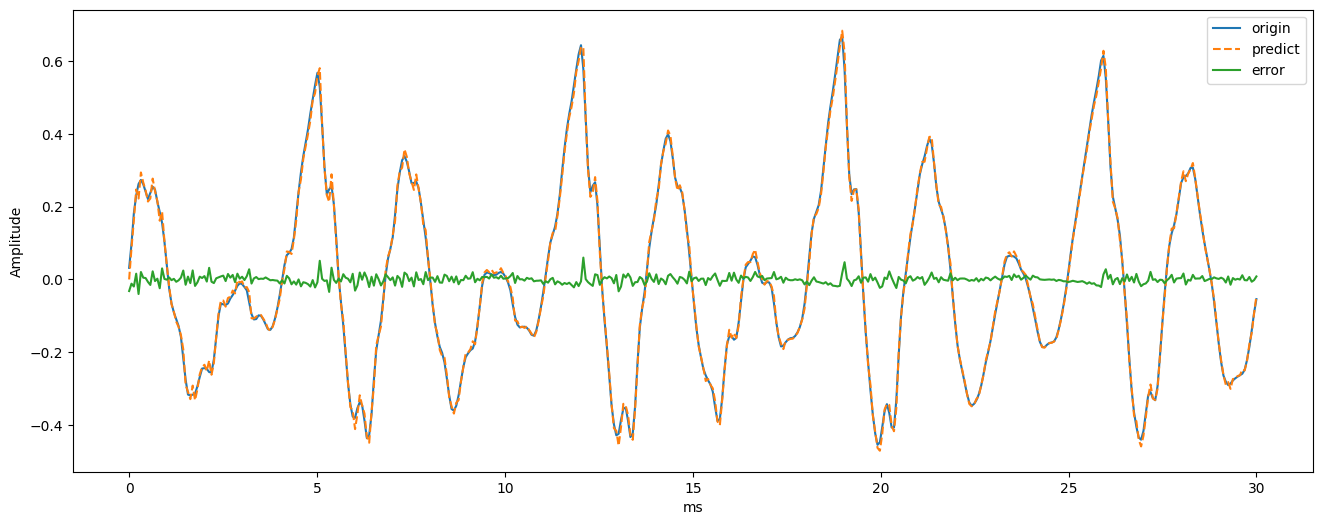

In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import librosa
import soundfile as sf
import scipy.signal as signal

orig_data, sr = sf.read('/mnt/lxc/librispeech/test-clean/test-clean-audio/8230/279154/8230-279154-0001.flac')

lpc_order = 10
frange = [37760, 38240]

# 截取音频片段
y_origin = orig_data[frange[0]:frange[1]]

# 计算LPC
lpc_coefficients = librosa.lpc(y_origin, order = lpc_order)
print(f"lpc_coefficients: {lpc_coefficients}")
# 计算预测值
filter_coefficients = np.hstack([[0], -1 * lpc_coefficients[1:]])
y_predict = scipy.signal.lfilter(filter_coefficients, [1], y_origin)

# 创建时间轴
duration = len(y_origin)/16
time = np.linspace(0, duration, len(y_origin))
plt.figure(figsize=(16, 6))
plt.xlabel('ms')
plt.ylabel('Amplitude')
plt.plot(time, y_origin, label='origin')
plt.plot(time, y_predict, label='predict', linestyle='--')
plt.plot(time, y_predict-y_origin, label='error')
plt.legend(loc='best')
plt.savefig('./fig/lpc_predict.png')

LPC滤波器的极点为： [-3.72166467+0.j         -0.66123998+0.54677365j -0.66123998-0.54677365j
  0.17222341+0.68873783j  0.17222341-0.68873783j  0.65868113+0.j
  0.51784409+0.40309931j  0.51784409-0.40309931j  0.15285833+0.38993244j
  0.15285833-0.38993244j]
LPC滤波器的零点为： []


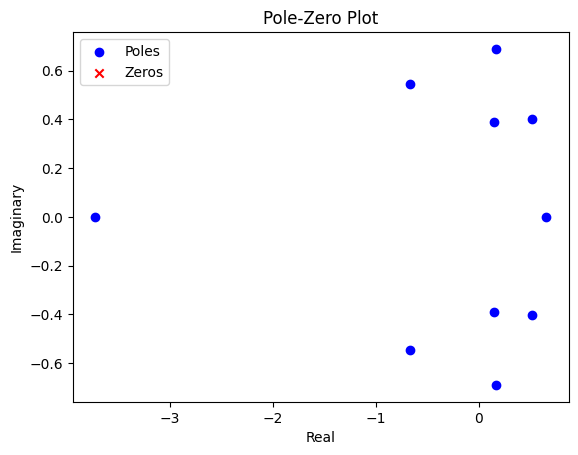

In [3]:
## 生成LPC滤波器的极点和零点

# 计算LPC滤波器的分母多项式
den_coeffs = np.zeros(lpc_order + 1)
den_coeffs[0] = 1
den_coeffs[1:] = -lpc_coefficients[1:]

# 计算滤波器的极点和零点
z, p, k = signal.tf2zpk([1], den_coeffs)

print("LPC滤波器的极点为：", p)
print("LPC滤波器的零点为：", z)

# 绘制极点和零点的散点图
fig, ax = plt.subplots()
ax.scatter(p.real, p.imag, marker='o', color='blue', label='Poles')
ax.scatter(z.real, z.imag, marker='x', color='red', label='Zeros')
ax.set_title('Pole-Zero Plot')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')
ax.legend()
plt.show()

In [4]:
def lpc_to_lsf(all_lpc):
    if len(all_lpc.shape) < 2:
        all_lpc = all_lpc[None]
    order = all_lpc.shape[1] - 1
    all_lsf = np.zeros((len(all_lpc), order))
    for i in range(len(all_lpc)):
        lpc = all_lpc[i]
        lpc1 = np.append(lpc, 0)
        lpc2 = lpc1[::-1]
        sum_filt = lpc1 + lpc2
        diff_filt = lpc1 - lpc2

        if order % 2 != 0:
            deconv_diff, _ = scipy.signal.deconvolve(diff_filt, [1, 0, -1])
            deconv_sum = sum_filt
        else:
            deconv_diff, _ = scipy.signal.deconvolve(diff_filt, [1, -1])
            deconv_sum, _ = scipy.signal.deconvolve(sum_filt, [1, 1])

        roots_diff = np.roots(deconv_diff)
        roots_sum = np.roots(deconv_sum)
        angle_diff = np.angle(roots_diff)
        angle_sum = np.angle(roots_sum)
        angle_diff = angle_diff[np.where(angle_diff > 0)]
        angle_sum = angle_sum[np.where(angle_sum > 0)]
        lsf = np.sort(np.hstack((angle_diff, angle_sum)))
        if len(lsf) != 0:
            all_lsf[i] = lsf
    return np.squeeze(all_lsf)

lsf_coefficients = lpc_to_lsf(lpc_coefficients)
print(f"lsf_coefficients: {lsf_coefficients}")

lsf_coefficients: [0.14889115 0.17644035 0.57424533 0.78090105 0.97655957 1.20280081
 1.41932438 1.89095214 2.38017636 2.59754937]


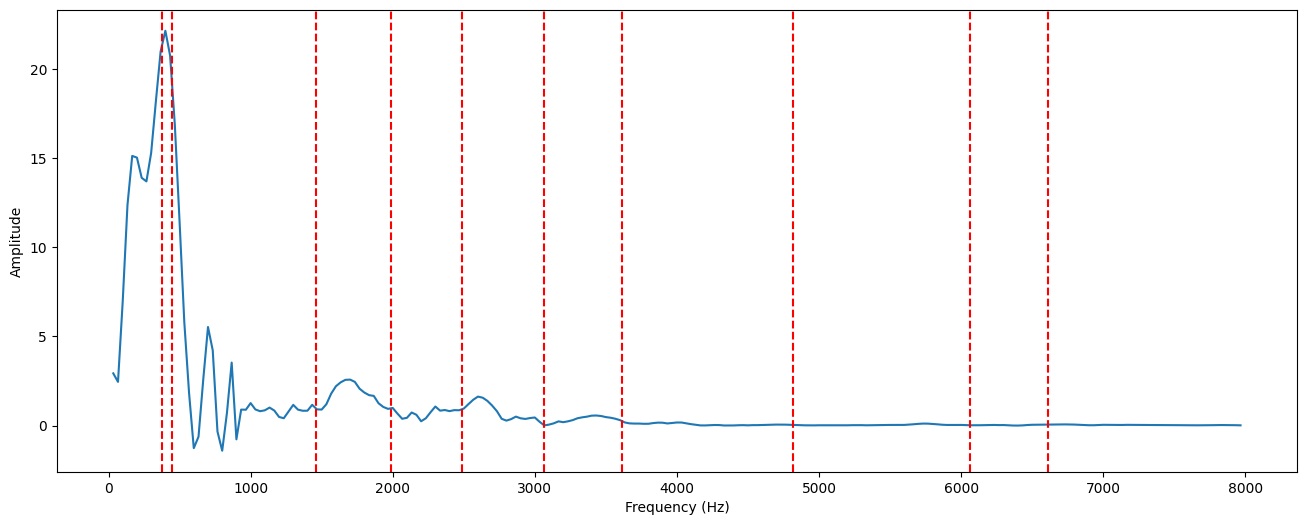

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks,savgol_filter


# 计算快速傅里叶变换
fft = np.fft.fft(y_origin)
freqs = np.fft.fftfreq(len(y_origin), 1/sr)

# 使用Savitzky-Golay滤波器平滑曲线
smoothed = savgol_filter(np.abs(fft), 31, 12)

# 绘制共振峰曲线
plt.figure(figsize=(16, 6))
plt.plot(freqs[freqs>0], smoothed[freqs>0])
# plt.plot(freqs[freqs>0], np.abs(fft)[freqs>0])
for i in lsf_coefficients:
    plt.axvline(i/np.pi*sr/2, color='r', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.savefig('./fig/lsf.png')

Resonance frequency: 0.40 Hz


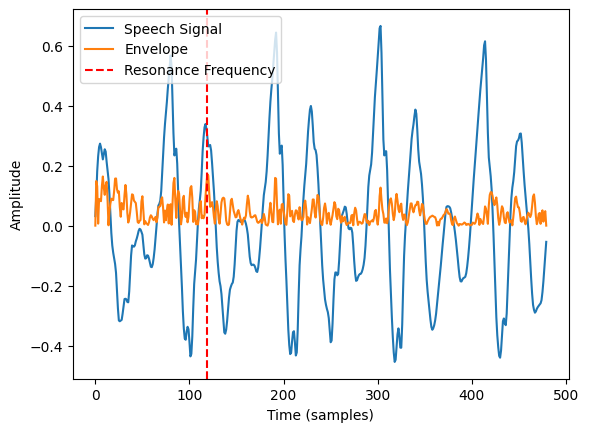